In [1]:
import numpy as np
import pandas as pd
import librosa

import os
import time
import re
from tqdm import tqdm
import h5py

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model

import matplotlib.pyplot as plt
import IPython.display
import librosa.display
from glob import glob
from sklearn.model_selection import KFold

import ESC

# Use GPU
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4556404922156737173
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17674030960460037647
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7046801664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12176887270990999299
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10363782258781378986
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

def extract_features(raw_data, label, bands = 60, frames = 41):
    window_size = 512 * (frames - 1)
    log_specgrams = []
    labels = []
    
    for num, audio in enumerate(tqdm(raw_data)):
        #sound_clip, s = librosa.load(fn) # 5sec
        #sound_clip   = np.concatenate((sound_clip,sound_clip),axis=None) # make it 10s
        #label = fn.split("/")[-1].split("-")[-1].split(".")[0]
        for (start,end) in windows(audio,window_size):
            if(len(audio[start:end]) == window_size):
                signal = audio[start:end]
                melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                logspec = librosa.core.amplitude_to_db(melspec)
                logspec = logspec.T.flatten()[:, np.newaxis].T
                log_specgrams.append(logspec)
                labels.append(label[num])
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(labels,dtype = np.int)

def extract_features_original(bands=60, frames=41):
    window_size = 512 * (frames - 1)
    log_specgrams = []
    cvs = []
    labels = []
    for fn in tqdm(glob('audio/*')):
        sound_clip,s = librosa.load(fn) # 5sec
        #sound_clip   = np.concatenate((sound_clip,sound_clip),axis=None) # make it 10s
        
        # Split the file name
        name_splitted = fn.split("\\")
        name_splitted = re.split('[\-.]', name_splitted[1])

        # Append a row of 3 elements
        fold = name_splitted[0]
        label = name_splitted[3]
        
        #label = fn.split("/")[-1].split("-")[-1].split(".")[0]
        for (start,end) in windows(sound_clip,window_size):
            if(len(sound_clip[start:end]) == window_size):
                signal = sound_clip[start:end]
                melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                logspec = librosa.core.amplitude_to_db(melspec)
                logspec = logspec.T.flatten()[:, np.newaxis].T
                log_specgrams.append(logspec)
                labels.append(label)
                cvs.append(fold)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(labels, dtype=np.int), np.array(cvs, dtype=np.int)

In [3]:
'''
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [3, 4], [3, 4], [3, 4], [3, 4], [3, 4], [3, 4]])
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)

iterat = iter(kf.split(X))
idx = next(iterat)
print(idx)
'''

'\nX = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [3, 4], [3, 4], [3, 4], [3, 4], [3, 4], [3, 4]])\nkf = KFold(n_splits=5, shuffle=True)\nkf.get_n_splits(X)\n\niterat = iter(kf.split(X))\nidx = next(iterat)\nprint(idx)\n'

In [4]:
# Load raw data
'''
PATH = 'audio'
raw_files, cvs, labels = ESC.Load_RAW(PATH)

# Split the different folds
f1, f2, f3, f4, f5 = ESC.Split_Folds(raw_files, cvs, labels, verbose=True)

# Load
af1, alf1 = ESC.Split_Data_Label(f1)
af2, alf2 = ESC.Split_Data_Label(f2)
af3, alf3 = ESC.Split_Data_Label(f3)
af4, alf4 = ESC.Split_Data_Label(f4)
af5, alf5 = ESC.Split_Data_Label(f5)
'''

features, labels, cvs = extract_features_original()


kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(features)

# Get only the first split
iterat = iter(kf.split(features))
t_idx, v_idx = next(iterat)

train_data, train_label = features[t_idx], labels[t_idx]
validation_data, validation_label = features[v_idx], labels[v_idx]

'''
# Split the different folds
f1, f2, f3, f4, f5 = ESC.Split_Folds(features, cvs, labels, verbose=True)

# Load
af1, alf1 = ESC.Split_Data_Label(f1)
af2, alf2 = ESC.Split_Data_Label(f2)
af3, alf3 = ESC.Split_Data_Label(f3)
af4, alf4 = ESC.Split_Data_Label(f4)
af5, alf5 = ESC.Split_Data_Label(f5)
'''

100%|██████████| 2000/2000 [06:08<00:00,  5.43it/s]


'\n# Split the different folds\nf1, f2, f3, f4, f5 = ESC.Split_Folds(features, cvs, labels, verbose=True)\n\n# Load\naf1, alf1 = ESC.Split_Data_Label(f1)\naf2, alf2 = ESC.Split_Data_Label(f2)\naf3, alf3 = ESC.Split_Data_Label(f3)\naf4, alf4 = ESC.Split_Data_Label(f4)\naf5, alf5 = ESC.Split_Data_Label(f5)\n'

In [5]:
train_label = to_categorical(train_label, num_classes=50)
validation_label = to_categorical(validation_label, num_classes=50)

In [6]:
'''
lf1_processed = to_categorical(alf1, num_classes=50)
lf2_processed = to_categorical(alf2, num_classes=50)
lf3_processed = to_categorical(alf3, num_classes=50)
lf4_processed = to_categorical(alf4, num_classes=50)
lf5_processed = to_categorical(alf5, num_classes=50)
'''

'\nlf1_processed = to_categorical(alf1, num_classes=50)\nlf2_processed = to_categorical(alf2, num_classes=50)\nlf3_processed = to_categorical(alf3, num_classes=50)\nlf4_processed = to_categorical(alf4, num_classes=50)\nlf5_processed = to_categorical(alf5, num_classes=50)\n'

In [7]:
# Compute the features
'''
f1_processed, lf1_processed = af1, lf1_processed
f2_processed, lf2_processed = af2, lf2_processed
f3_processed, lf3_processed = af3, lf3_processed
f4_processed, lf4_processed = af4, lf4_processed
f5_processed, lf5_processed = af5, lf5_processed
'''

'\nf1_processed, lf1_processed = af1, lf1_processed\nf2_processed, lf2_processed = af2, lf2_processed\nf3_processed, lf3_processed = af3, lf3_processed\nf4_processed, lf4_processed = af4, lf4_processed\nf5_processed, lf5_processed = af5, lf5_processed\n'

In [8]:
# label category names
'''
df = pd.read_csv(glob('meta/esc50.csv')[0])
df = df[['target','category']]
df = df.drop_duplicates().reset_index(drop=True)
df = df.sort_values(by=['target']).reset_index(drop=True)
df.head()

my_dict = {}
for i in range(len(df)):
    my_dict[df['target'][i]] = df['category'][i]
my_dict
'''

"\ndf = pd.read_csv(glob('meta/esc50.csv')[0])\ndf = df[['target','category']]\ndf = df.drop_duplicates().reset_index(drop=True)\ndf = df.sort_values(by=['target']).reset_index(drop=True)\ndf.head()\n\nmy_dict = {}\nfor i in range(len(df)):\n    my_dict[df['target'][i]] = df['category'][i]\nmy_dict\n"

In [9]:
#onehot_labels = to_categorical(labels,num_classes=50)

In [10]:
# Create train test Dataset
#rnd_indices = np.random.rand(len(labels)) < 0.70

#X_train = features[rnd_indices]
#y_train = onehot_labels[rnd_indices]
#X_test  = features[~rnd_indices]
#y_test  = onehot_labels[~rnd_indices]

In [11]:
#X_train.shape, y_train.shape, X_test.shape, y_test.shape

## Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,InputLayer
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ModelCheckpoint

def basemodel():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(60,41,2), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu', kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='softmax'))
    # Compile model
    epochs = 25
    lrate = 0.01
    decay = lrate/epochs
#     sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
    return model

In [19]:

model = basemodel()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 60, 41, 32)        608       
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 41, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 20, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 20, 64)        18496     
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 20, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 20, 64)       

## Training

In [14]:
def CreateTrainingSet(f1, lf1, batch_size=32):
    

    # Create dataset
    training_dataset = tf.data.Dataset.from_tensor_slices((f1, lf1))
    
    # Cache the dataset
    training_dataset = training_dataset.cache("training_cache")
    
    # Shuffle all elements at every iteration
    training_dataset = training_dataset.shuffle(len(training_dataset))
    
    # Define batch_size and prefetch size
    training_dataset = training_dataset.batch(batch_size=batch_size).prefetch(buffer_size=1)
    
    return training_dataset


def CreateValidationSet(f1, lf1, batch_size=32):
    
    f1 = f1.astype(dtype=np.float32)
    lf1 = lf1.astype(dtype=np.float32)
    
    # Create and cache training
    validation_dataset = tf.data.Dataset.from_tensor_slices((f1, lf1))
    
    # Cache dataset
    validation_dataset = validation_dataset.cache("validation_cache")
    
    # Shuffle all elements at every iteration
    #validation_dataset = validation_dataset.shuffle(len(validation_dataset))
    
    # Define batch_size and prefetch size
    validation_dataset = validation_dataset.batch(batch_size=batch_size).prefetch(buffer_size=1)
    
    return validation_dataset

In [15]:
import ESC


batch_size = 50
epochs = 10

#training_set = CreateTrainingSet(X_train, y_train, batch_size=batch_size)
#validation_set = CreateValidationSet(X_test, y_test, batch_size=batch_size)

training_dataset = CreateTrainingSet(train_data, train_label, batch_size=128)

validation_dataset = CreateValidationSet(validation_data, validation_label, batch_size=128)

In [18]:

history = model.fit(training_dataset,
                      steps_per_epoch=int(np.ceil(len(training_dataset) / float(128))),
                      epochs=1000,
                      validation_data=validation_dataset,
                      validation_steps=int(np.ceil(len(validation_dataset) / float(128))),
                      verbose=1,)

Epoch 1/1000
1/1 [==============================] - 0s 87ms/step - loss: 3.3993 - accuracy: 0.0859 - val_loss: 3.2686 - val_accuracy: 0.1641
Epoch 2/1000
1/1 [==============================] - 0s 85ms/step - loss: 3.2534 - accuracy: 0.1094 - val_loss: 3.2609 - val_accuracy: 0.1719
Epoch 3/1000
1/1 [==============================] - 0s 86ms/step - loss: 3.1418 - accuracy: 0.1328 - val_loss: 3.2470 - val_accuracy: 0.1797
Epoch 4/1000
1/1 [==============================] - 0s 87ms/step - loss: 3.1829 - accuracy: 0.1562 - val_loss: 3.2400 - val_accuracy: 0.1562
Epoch 5/1000
1/1 [==============================] - 0s 86ms/step - loss: 3.2143 - accuracy: 0.1094 - val_loss: 3.2386 - val_accuracy: 0.1797
Epoch 6/1000
1/1 [==============================] - 0s 85ms/step - loss: 3.2789 - accuracy: 0.0859 - val_loss: 3.2454 - val_accuracy: 0.1328
Epoch 7/1000
1/1 [==============================] - 0s 84ms/step - loss: 3.1501 - accuracy: 0.1484 - val_loss: 3.2158 - val_accuracy: 0.1562
Epoch 8/1000


In [20]:
max_epochs = 50

epoch_loss= []
epoch_acc = []

epoch_vl = []
epoch_va = []

# Loop over the epochs
for epoch in range(max_epochs):

    
    step_loss = []
    step_acc = []
    
    step_vl = []
    step_va = []
    
    start = time.time()
    # train over mini-batches
    for x_batch, y_batch in training_dataset:
        
        # train on batch
        step_stats = model.train_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_loss.append(step_stats[0])
        step_acc.append(step_stats[1])
        
    # compute validation stats
    for x_batch, y_batch in validation_dataset:
        
        # compute validation stats
        val_stats = model.test_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_vl.append(val_stats[0])
        step_va.append(val_stats[1])
    end = time.time()
        
    # Save the mean loss and accuracy of the entire epoch
    epoch_loss.append(np.mean(step_loss))
    epoch_acc.append(np.mean(step_acc))
    epoch_vl.append(np.mean(step_vl))
    epoch_va.append(np.mean(step_va))
    
    # Print epoch training stats
    print("Epoch %2d: \t t-loss: %3.6f \t t-acc: %.6f \t v-loss: %3.6f \t v-acc: %.6f \t time: %3.3f" % (epoch + 1, epoch_loss[-1], epoch_acc[-1], epoch_vl[-1], epoch_va[-1], (end - start)))
    

Epoch  1: 	 t-loss: 3.905628 	 t-acc: 0.032771 	 v-loss: 3.637538 	 v-acc: 0.045528 	 time: 8.786
Epoch  2: 	 t-loss: 3.403165 	 t-acc: 0.088150 	 v-loss: 3.183959 	 v-acc: 0.141433 	 time: 5.622
Epoch  3: 	 t-loss: 2.936455 	 t-acc: 0.178305 	 v-loss: 2.800633 	 v-acc: 0.208244 	 time: 5.703
Epoch  4: 	 t-loss: 2.597517 	 t-acc: 0.253319 	 v-loss: 2.465361 	 v-acc: 0.309267 	 time: 5.629
Epoch  5: 	 t-loss: 2.281105 	 t-acc: 0.333587 	 v-loss: 2.164556 	 v-acc: 0.361530 	 time: 5.686
Epoch  6: 	 t-loss: 2.062227 	 t-acc: 0.388966 	 v-loss: 1.983016 	 v-acc: 0.417026 	 time: 5.644
Epoch  7: 	 t-loss: 1.842135 	 t-acc: 0.450636 	 v-loss: 1.954600 	 v-acc: 0.429418 	 time: 5.665
Epoch  8: 	 t-loss: 1.704770 	 t-acc: 0.489215 	 v-loss: 1.802050 	 v-acc: 0.473060 	 time: 5.607
Epoch  9: 	 t-loss: 1.543030 	 t-acc: 0.535813 	 v-loss: 1.975021 	 v-acc: 0.441002 	 time: 5.722
Epoch 10: 	 t-loss: 1.394041 	 t-acc: 0.576950 	 v-loss: 1.654059 	 v-acc: 0.522899 	 time: 5.528
Epoch 11: 	 t-loss: 

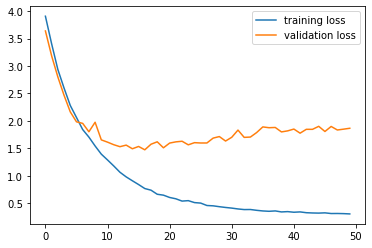

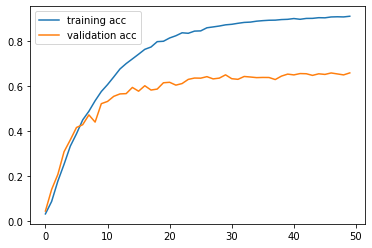

In [21]:
plt.figure()
plt.plot(epoch_loss, label='training loss')
plt.plot(epoch_vl, label='validation loss')
plt.legend()
plt.show()
plt.close('all')

plt.figure()
plt.plot(epoch_acc, label='training acc')
plt.plot(epoch_va, label='validation acc')
plt.legend()
plt.show()
plt.close('all')